In [1]:
from PosSelect_Functions_Old import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np
import copy
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import wilcoxon
from scipy.optimize import curve_fit
from scipy.stats import fisher_exact
from scipy.stats import norm
from collections import Counter

hfont = {'fontname':'Arial'}
plt.rcParams["font.family"] = "Arial"

#Code borrowed heavily from here: https://stackoverflow.com/questions/62375034/find-non-overlapping-area-between-two-kde-plots
plt.rcParams.update(
    {"text.usetex": False}
)

def parse_table(i):
    return [int(x) for x in i.replace("[", "").replace("]", "").split(",")]

def control(x, y, iteration, cut=0.05):
    np.random.seed(iteration)
    #Compute log fold-change
    dif = np.log2(x[:, None] / y)
    
    #Get the positive, negative, and zero log fold-changes that are less than the cutoff
    pos = np.where((dif < cut) & (dif > 0))
    neg = np.where((dif > -cut) & (dif < 0))
    zero = np.where((dif == 0))
    
    #Randomly shuffle the dataframes then drop duplicates
    pos = pd.DataFrame(list(zip(pos[0], pos[1]))).sample(frac=1, replace = False).drop_duplicates(0).drop_duplicates(1)
    pos["PosNegZero"] = np.repeat("Pos", pos.shape[0])
    pos.index = range(0, pos.shape[0])
    neg = pd.DataFrame(list(zip(neg[0], neg[1]))).sample(frac=1, replace = False).drop_duplicates(0).drop_duplicates(1)
    neg["PosNegZero"] = np.repeat("Neg", neg.shape[0])
    neg.index = range(pos.shape[0], pos.shape[0] + neg.shape[0])
    zero = pd.DataFrame(list(zip(zero[0], zero[1]))).sample(frac=1, replace = False).drop_duplicates(0).drop_duplicates(1)
    zero["PosNegZero"] = np.repeat("Zero", zero.shape[0])
    zero.index = range(pos.shape[0] + neg.shape[0], pos.shape[0] + neg.shape[0] + zero.shape[0])
    
    #Concatenate everything together then make new dataframes for pos, neg, and zero
    df = pd.concat([pos, neg, zero]).sample(frac=1, replace = False).drop_duplicates(0).drop_duplicates(1)
    df_pos = df[df["PosNegZero"].isin(["Pos"])].copy()
    df_neg = df[df["PosNegZero"].isin(["Neg"])].copy()
    df_zero = df[df["PosNegZero"].isin(["Zero"])].copy()
    
    #Downsample so that there are the same number of pos and same number of neg genes in there.
    if df_pos.shape[0] > df_neg.shape[0]:
        df_pos = df_pos.sample(frac=df_neg.shape[0]/df_pos.shape[0], replace = False)
    elif df_neg.shape[0] > df_pos.shape[0]:
        df_neg = df_neg.sample(frac=df_pos.shape[0]/df_neg.shape[0], replace = False)
    df = pd.concat([df_pos, df_neg, df_zero])
    df[0] = df[0].astype(int)
    df[1] = df[1].astype(int)
    #Return the result
    return df

def remove_pseudos(v, yvalls, path = "./"):        
    v_pseudos = pd.read_csv("Pseudos_Repeats/HumChp_NC_Final_Rmdup_CREs_NoHLA_Pseudos.bed", header = None, sep = "\t")
    vv_pseudos = pd.read_csv("Pseudos_Repeats/HumPoly_NC_Final_CREs_NoHLA_Pseudos.bed", header = None, sep = "\t")
    v_pseudos = list(v_pseudos[0] + ":" + v_pseudos[2].astype(str))
    vv_pseudos = list(vv_pseudos[0] + ":" + vv_pseudos[2].astype(str))

    vp2 = pd.read_csv("Pseudos_Repeats/HumChp_NC_Final_Rmdup_CREs_NoHLA_PseudosFromGTF.bed", header = None, sep = "\t")
    vvp2 = pd.read_csv("Pseudos_Repeats/HumPoly_NC_Final_CREs_NoHLA_PseudosFromGTF.bed", header = None, sep = "\t")
    v_pseudos = v_pseudos + list(vp2[0] + ":" + vp2[2].astype(str))
    vv_pseudos = vv_pseudos + list(vvp2[0] + ":" + vvp2[2].astype(str))

    vp2 = pd.read_csv("Pseudos_Repeats/HumChp_NC_Final_Rmdup_CREs_NoHLA_2WayPseudosFromGTF.bed", header = None, sep = "\t")
    vvp2 = pd.read_csv("Pseudos_Repeats/HumPoly_NC_Final_CREs_NoHLA_2WayPseudosFromGTF.bed", header = None, sep = "\t")
    v_pseudos = v_pseudos + list(vp2[0] + ":" + vp2[2].astype(str))
    vv_pseudos = vv_pseudos + list(vvp2[0] + ":" + vvp2[2].astype(str))

    v = v[~v["Position"].isin(v_pseudos)]
    yvalls = yvalls[~yvalls["Position"].isin(vv_pseudos)]
    return v, yvalls

def remove_repeats(v, yvalls, path = "./"):
    v_repeat = pd.read_csv("Pseudos_Repeats/HumChp_NC_Final_CREs_NoHLA_rmsk.txt", sep = "\t", header = None)
    vv_repeat = pd.read_csv("Pseudos_Repeats/HumPoly_NC_Final_CREs_NoHLA_rmsk.txt", sep = "\t", header = None)
    v_repeat = list(v_repeat[v_repeat[1] != "."][0])
    vv_repeat = list(vv_repeat[vv_repeat[1] != "."][0])
    v = v[~v["Position"].isin(v_repeat)]
    yvalls = yvalls[~yvalls["Position"].isin(vv_repeat)]
    return v, yvalls


d_abrev = {"LiangSteinNeuron":"FC exc. neur.", "FetalChondrocytes":"F chond.", "SertoliMale":"FG sertoli", "preGC_IIaFemale":"FG preGC IIa",\
          "NeuralFemale":"FG neur.", "FetalGonadImmuneFemale":"FG immune", "VIP":"AC VIP inh. neur.", "LiangSteinProgenitor":"FC prog.",\
          "AdultHeartVentricularCardiomyocyte":"AH cardiomyo.", "AdultLoopOfHenle":"AK loop of henle", "FetalBrainNeurGlioblast_CB_VZ":"FCB glioblast",\
         "AdultProximalTubule":"AK prox. tub.", "FetalLeydigMale":"FG leydig", "SST":"AC SST inh neur.", "KosoyRoussosControlMicroglia":"AC microglia",\
         "FetalBrainFloorPlate":"FB fl. plate", "FetalArterialECs":"FH endoth.", "ASCT":"AC astro.", "FetalBrainCOP":"FB COP",\
         "AMY":"AA neur.", "PVALB":"AC PVALB inh neur.", "ITL23":"AC L2-3 IT neur.", "FetalBrainNeurCB_GNP_IPC_1":"FB inter. prog.", "FetalBrainNeurDAergic":"FB DA neur.",\
          "OGC":"AC Oligo.", "D1Pu":"AP D1 inh neur.", "FetalBrainNeurSerotonergic":"FB 5-HT neur.", "FetalBrainNeurDRG_2":"FS DRG neur.",\
          "FetalHeartPericytes":"FH peri.", "FetalHeartEndocardium":"FH endocard.", "FetalHeartCardiacFibroblasts":"FH fibro.", "FetalBrainNeurPurkinje_6":"FCB Purk. inh neur.",\
          "AdultHeartSmoothMuscle":"AH smooth musc.", "FetalBrainRoofPlate":"FB ro. plate"}

C:\Users\astar\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
v = pd.read_csv("Fixed_LiangSteinNeuron.txt.gz", sep = "\t")
vv = pd.read_csv("Poly_MAF0.25_LiangSteinNeuron.txt.gz", sep = "\t")
vv = add_unfold(vv)




KeyboardInterrupt



In [ ]:
vv.index = vv["Position"]
p = pd.read_csv("Pseudos_Repeats/HumPoly_NC_Final_CREs_NoHLA_rmsk.txt", sep = "\t", header = None).set_index(0)
vv = vv.join(p)

v.index = v["Position"]
p = pd.read_csv("Pseudos_Repeats/HumChp_NC_Final_CREs_NoHLA_rmsk.txt", sep = "\t", header = None).set_index(0)
v = v.join(p)

In [ ]:
v_count = Counter(v.drop_duplicates("Position")[1])
vv_count = Counter(vv.drop_duplicates("Position")[1])

out = []
for key in np.unique(list(v_count.keys()) + list(vv_count.keys())):
    if v_count[key] > 100 or vv_count[key] > 100:
        out.append([key, v_count[key], vv_count[key], (v_count[key]/vv_count[key])/(v.shape[0]/vv.shape[0])])
        
df = pd.DataFrame(out).sort_values(3)
df.columns = ["RepeatClass", "NumberFixedVariants", "NumberPolymorphicVariants", "NormalizedRatio"]
df.to_csv("Repeat_NumVar.txt", sep = "\t")

In [ ]:
v, vv = read_noncoding_data_fast(path = "./", maf_cut = 0.1, spec_sup = 0)

In [13]:
vv.index = vv["Position"]
p = pd.read_csv("Pseudos_Repeats/HumPoly_NC_Final_CREs_NoHLA_rmsk.txt", sep = "\t", header = None).set_index(0)
vv = vv.join(p)

v.index = v["Position"]
p = pd.read_csv("Pseudos_Repeats/HumChp_NC_Final_CREs_NoHLA_rmsk.txt", sep = "\t", header = None).set_index(0)
v = v.join(p)

In [14]:
toss = list(df[df["NormalizedRatio"] < 0.75]["RepeatClass"])
v_toss = v[v[1].isin(toss)]
vv_toss = vv[vv[1].isin(toss)]

In [16]:
print(len(v_toss.index), len(vv_toss.index), len(v.index), len(vv.index))

310281 475850 10767387 6884328


In [20]:
v_toss[["Position"]]

,Position
Position,
chr1:907181,chr1:907181
chr1:928308,chr1:928308
chr1:928398,chr1:928398
chr1:1094525,chr1:1094525
chr1:1094633,chr1:1094633
...,...
chrX:155554885,chrX:155554885
chrX:155581378,chrX:155581378
chrX:155581400,chrX:155581400


In [23]:
toss_all = pd.concat([v_toss[["Position"]], vv_toss[["Position"]]])
toss_all.to_csv("BlacklistTE_Variants.txt", sep = "\t", index = False)

In [3]:
v = pd.read_csv("Fixed_LiangSteinNeuron.txt.gz", sep = "\t")
vv = pd.read_csv("Poly_MAF0.25_LiangSteinNeuron.txt.gz", sep = "\t")
vv = add_unfold(vv)

vv_ref = vv[vv["Human ref"] == vv["Chimp ref"]]
vv_alt = vv[vv["Human alt"] == vv["Chimp ref"]]
vv_ref["fixed logfc"] = -vv_ref["logfc"].astype(float)
vv_alt["fixed logfc"] = vv_alt["logfc"].astype(float)
vv = pd.concat([vv_ref, vv_alt])

C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:559: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yvalls_alt["UnfoldedMAF"] = 1-yvalls_alt["MAFMaxAcrossAncestry"]
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:560: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yvalls_ref["UnfoldedMAF"] = yvalls_ref["MAFMaxAcrossAncestry"]
C:\Users\astar\AppData\Local\Temp\ipykernel_11764\525756865.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [4]:
vv.index = vv["Position"]
p = pd.read_csv("Pseudos_Repeats/HumPoly_NC_Final_CREs_NoHLA_rmsk.txt", sep = "\t", header = None).set_index(0)
vv = vv.join(p)

v.index = v["Position"]
p = pd.read_csv("Pseudos_Repeats/HumChp_NC_Final_CREs_NoHLA_rmsk.txt", sep = "\t", header = None).set_index(0)
v = v.join(p)

In [5]:
recently_mobile = ["AluY", "AluYb8", "AluYa5", "L1HS", "AluYb9", "AluYf4", "AluYg6", "AluYc", "AluYa8", "SVA_F", "AluYd8", "AluYk12", "AluYk11", "L1PA2", "LTR5_Hs", "SVA_E", "AluYh9", "SVA_D", "L1P1", "AluYk4"]
len(recently_mobile)

20

SignificanceResult(statistic=0.8621220778073412, pvalue=5.694903373791685e-62)
(-0.1598975482079633, 0.098915376, [[43551, 454642], [20794, 187155]], [[43551, 454642], [20795, 187154]], <Figure size 1000x600 with 1 Axes>)


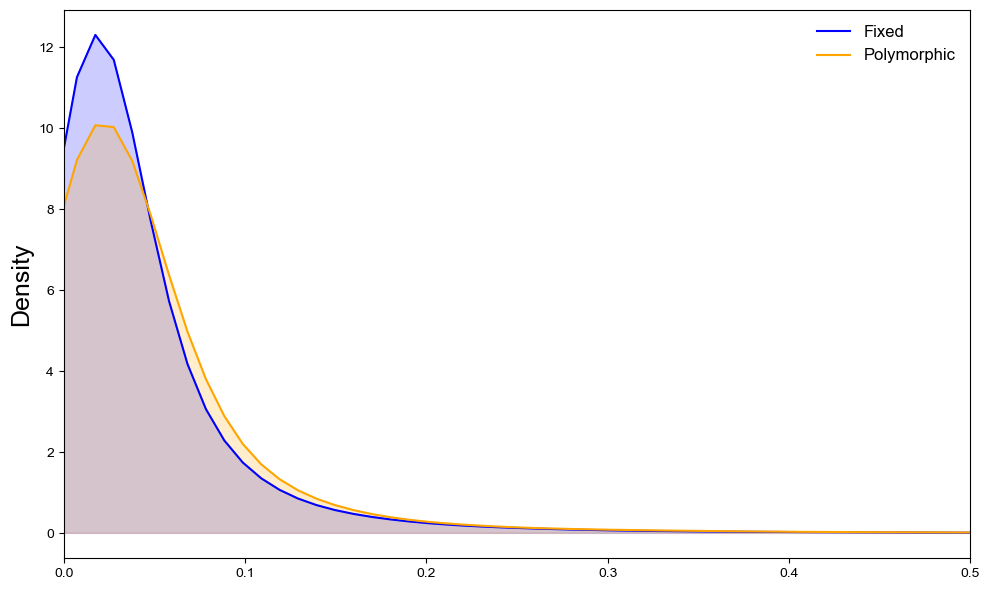

In [6]:
metric = "abs logfc"
v2k = v[(v["SpecSup447"] > -1) & (v["SpecSup447"] <= 19)].copy()
#v2k = v2k[v2k["PhyloP447"] < 0.25]
vv2k = vv[(vv["SpecSup447"] > -1) & (vv["SpecSup447"] <= 19)].copy()
#vv2k = vv2k[vv2k["PhyloP447"] < 0.25]
x2 = [np.float64(x) for x in list(v2k[metric])]
yvals2 = [np.float64(j) for j in list(vv2k[metric])]

yvals2.sort()
vvv = prepare_alpha(v2k, vv2k, stat = metric)
cuttt = 0.9
cutoff = yvals2[int(floor((len(yvals2)*cuttt)))]
alpha = compute_alpha_cutoff(vvv, dn_cut = 0.05, plot = True, cutoff = cutoff, window = [0, 0.5])
print(fisher_exact(alpha[-2]))
print(alpha)

SignificanceResult(statistic=0.872966572833873, pvalue=0.01041994038996234)
(-0.14440977273827837, 0.026018048, [[2209, 2528], [1031, 1032]], [[2209, 2528], [1032, 1031]], <Figure size 1000x600 with 1 Axes>)


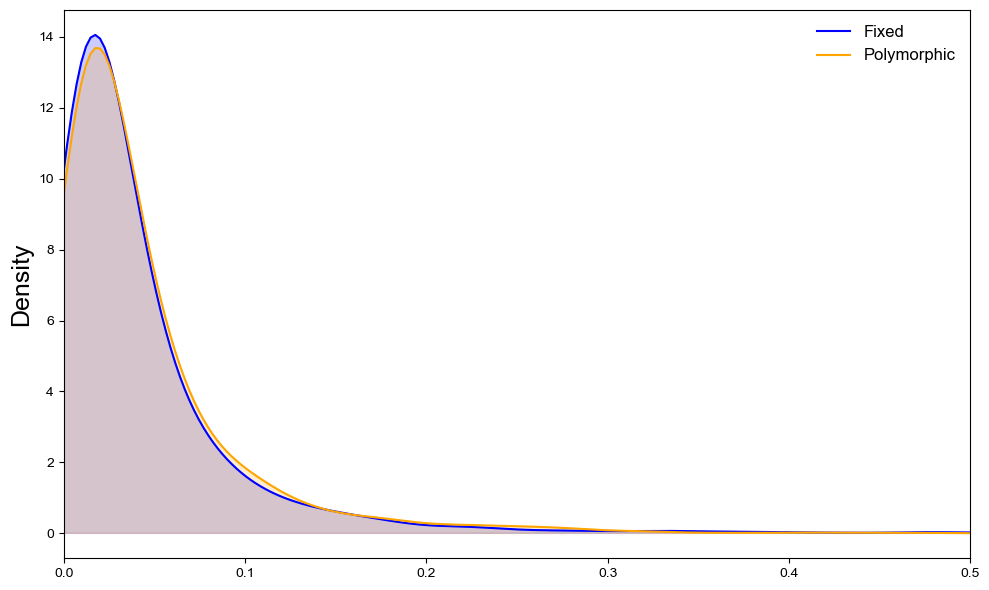

In [101]:
metric = "abs logfc"
v2k = v[(v["SpecSup447"] > -1) & (v["SpecSup447"] <= 19)].copy()
vv2k = vv[(vv["SpecSup447"] > -1) & (vv["SpecSup447"] <= 19)].copy()

v2k = v2k[v2k[1].isin(["AluYk3"])]
vv2k = vv2k[vv2k[1].isin(["AluYk3"])]

x2 = [np.float64(x) for x in list(v2k[metric])]
yvals2 = [np.float64(j) for j in list(vv2k[metric])]

yvals2.sort()
vvv = prepare_alpha(v2k, vv2k, stat = metric)
cuttt = 0.5
cutoff = yvals2[int(floor((len(yvals2)*cuttt)))]
alpha = compute_alpha_cutoff(vvv, dn_cut = 0.05, plot = True, cutoff = cutoff, window = [0, 0.5])
print(fisher_exact(alpha[-2]))
print(alpha)

In [64]:
df = pd.read_csv("Repeat_NumVar.txt", sep = "\t")
df.head(50)

,Unnamed: 0,RepeatClass,NumberFixedVariants,NumberPolymorphicVariants,NormalizedRatio
0,316,L1PA2,2791,7211,0.094572
1,317,L1PA3,13698,22909,0.146100
2,207,L1HS,349,557,0.153098
3,521,LTR5A,497,430,0.282415
4,318,L1PA4,34321,24147,0.347294
5,163,HERVH-int,13675,9075,0.368197
6,954,SVA_A,607,376,0.394458
7,296,L1P1,5148,3121,0.403037
8,169,HERVK-int,530,320,0.404693
9,552,LTR7Y,342,203,0.411652


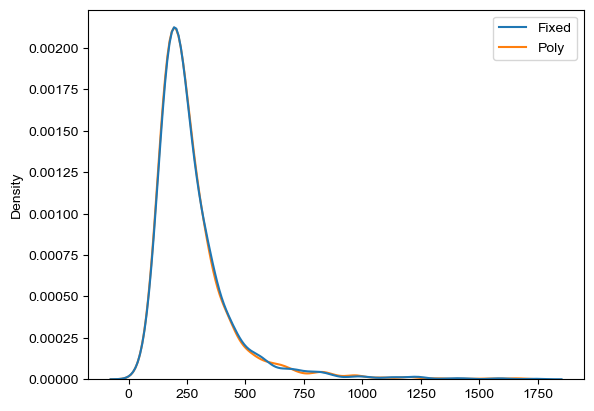

SignificanceResult(statistic=0.8412698412698413, pvalue=0.009430194837475127)
(-0.18739971972297254, 0.0260548089999999, [[848, 1008], [927, 929]], [[848, 1008], [928, 928]], <Figure size 1000x600 with 1 Axes>)


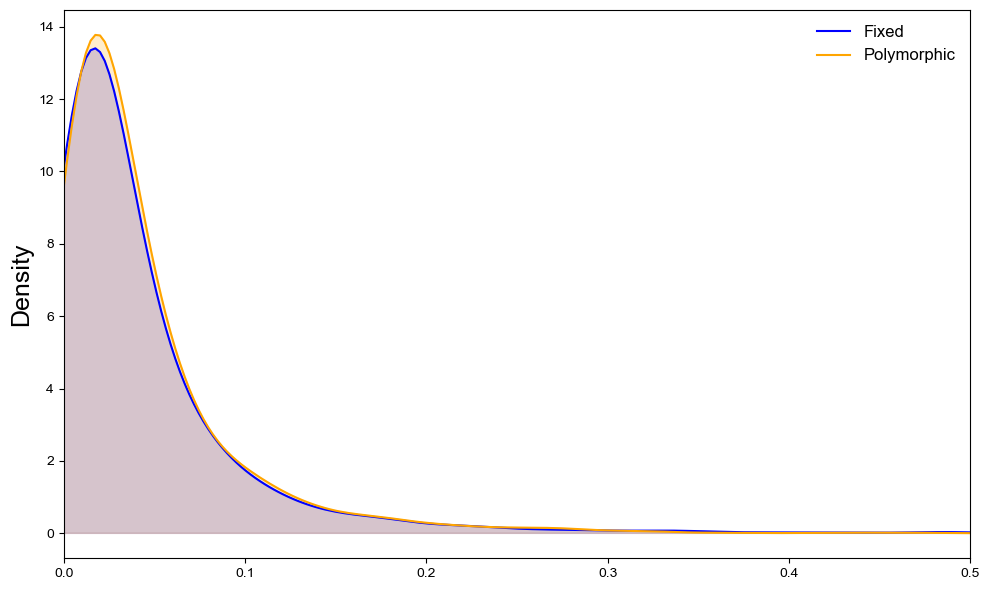

In [102]:
cont = control(np.array(v2k["allele2_pred_counts"]), np.array(vv2k["allele2_pred_counts"]), iteration = 1)


v2k_keep = v2k.iloc[cont[0]].copy()
vv2k_keep = vv2k.iloc[cont[1]].copy()

sns.kdeplot({"Fixed":list(v2k_keep["allele1_pred_counts"]), "Poly":list(vv2k_keep["allele1_pred_counts"])})
plt.show()
x2 = [np.float64(x) for x in list(v2k_keep[metric])]
yvals2 = [np.float64(j) for j in list(vv2k_keep[metric])]

yvals2.sort()
vvv = prepare_alpha(v2k_keep, vv2k_keep, stat = metric)
cuttt = 0.5
cutoff = yvals2[int(floor((len(yvals2)*cuttt)))]
alpha = compute_alpha_cutoff(vvv, dn_cut = 0.05, plot = True, cutoff = cutoff, window = [0, 0.5])
print(fisher_exact(alpha[-2]))
print(alpha)

In [103]:
x = v2k[v2k["abs logfc"] > 0.1]
y = vv2k[vv2k["abs logfc"] > 0.1]
up = x[x["logfc"] > 0].shape[0]
down = x[x["logfc"] < 0].shape[0]
up_poly = y[y["fixed logfc"] > 0].shape[0]
down_poly = y[y["fixed logfc"] < 0].shape[0]

fisher_exact([[up, down], [up_poly, down_poly]])

SignificanceResult(statistic=1.4490207191888658, pvalue=0.042445712002456226)

In [46]:
down_poly

163

In [99]:
x = v2k_keep[v2k_keep["abs logfc"] > 0.1]
y = vv2k_keep[vv2k_keep["abs logfc"] > 0.1]
up = x[x["logfc"] > 0].shape[0]
down = x[x["logfc"] < 0].shape[0]
up_poly = y[y["fixed logfc"] > 0].shape[0]
down_poly = y[y["fixed logfc"] < 0].shape[0]

fisher_exact([[up, down], [up_poly, down_poly]])

SignificanceResult(statistic=0.9577221742881795, pvalue=0.8956237808620386)

C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poly["FixedOrPoly"] = y
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed["FixedOrPoly"] = x
C:\Users\astar\PosSelect_ForPub\PosSelect_Functions_Old.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

SignificanceResult(statistic=0.6642540545095008, pvalue=1.5896678895680832e-09)
(-0.5039626986630505, 0.037010297, [[631, 949], [1012, 1013]], [[631, 949], [1013, 1012]], <Figure size 1000x600 with 1 Axes>)


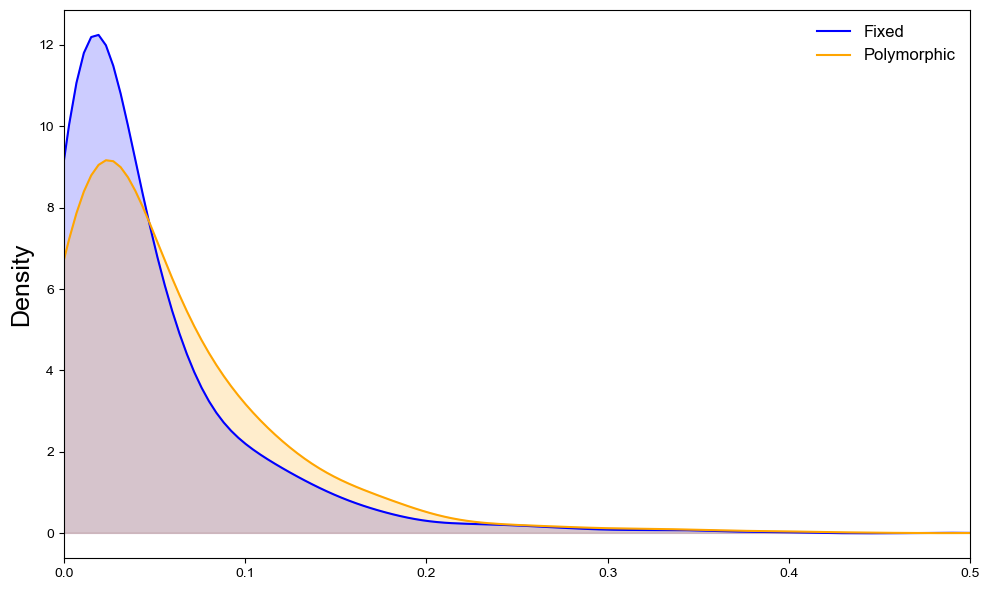

In [27]:
v2k_keep = v2k[(v2k["allele1_pred_counts"] > 100) | (v2k["allele2_pred_counts"] > 100)]
vv2k_keep = vv2k[(vv2k["allele1_pred_counts"] > 100) | (vv2k["allele2_pred_counts"] > 100)]

x2 = [np.float64(x) for x in list(v2k_keep[metric])]
yvals2 = [np.float64(j) for j in list(vv2k_keep[metric])]

yvals2.sort()
vvv = prepare_alpha(v2k_keep, vv2k_keep, stat = metric)
cuttt = 0.5
cutoff = yvals2[int(floor((len(yvals2)*cuttt)))]
alpha = compute_alpha_cutoff(vvv, dn_cut = 0.05, plot = True, cutoff = cutoff, window = [0, 0.5])
print(fisher_exact(alpha[-2]))
print(alpha)

SignificanceResult(statistic=0.8831328046066037, pvalue=1.0002787107351943e-38)
(-0.13229710199489408, 0.09826345, [[40115, 408804], [17757, 159820]], [[40115, 408804], [17758, 159819]], <Figure size 1000x600 with 1 Axes>)


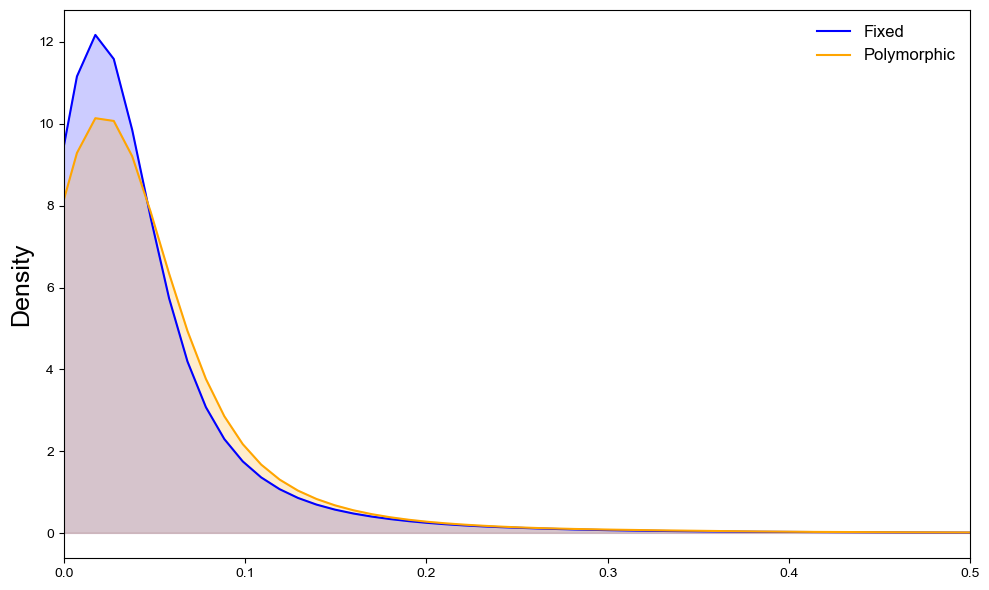

In [8]:
metric = "abs logfc"
v2k = v[(v["SpecSup447"] > -1) & (v["SpecSup447"] <= 19)].copy()
vv2k = vv[(vv["SpecSup447"] > -1) & (vv["SpecSup447"] <= 19)].copy()

v2k = v2k[~v2k[1].isin(recently_mobile)]
vv2k = vv2k[~vv2k[1].isin(recently_mobile)]

x2 = [np.float64(x) for x in list(v2k[metric])]
yvals2 = [np.float64(j) for j in list(vv2k[metric])]

yvals2.sort()
vvv = prepare_alpha(v2k, vv2k, stat = metric)
cuttt = 0.9
cutoff = yvals2[int(floor((len(yvals2)*cuttt)))]
alpha = compute_alpha_cutoff(vvv, dn_cut = 0.05, plot = True, cutoff = cutoff, window = [0, 0.5])
print(fisher_exact(alpha[-2]))
print(alpha)

In [40]:
Counter(v2k[1])

Counter({'AluY': 36392,
         'LTR5_Hs': 821,
         'AluYk4': 1807,
         'L1PA2': 2396,
         'AluYc': 2515,
         'L1P1': 4576,
         'AluYa5': 206,
         'AluYh9': 67,
         'L1HS': 241,
         'AluYa8': 53,
         'AluYk11': 23,
         'AluYb8': 69,
         'AluYk12': 25,
         'AluYg6': 47,
         'AluYd8': 6,
         'SVA_F': 4,
         'SVA_E': 9,
         'AluYb9': 13,
         'SVA_D': 4})

SignificanceResult(statistic=0.7221348797250859, pvalue=0.013870737354171056)
(-0.37709730954774456, 0.12744495, [[187, 2328], [99, 900]], [[187, 2328], [100, 899]], <Figure size 1000x600 with 1 Axes>)


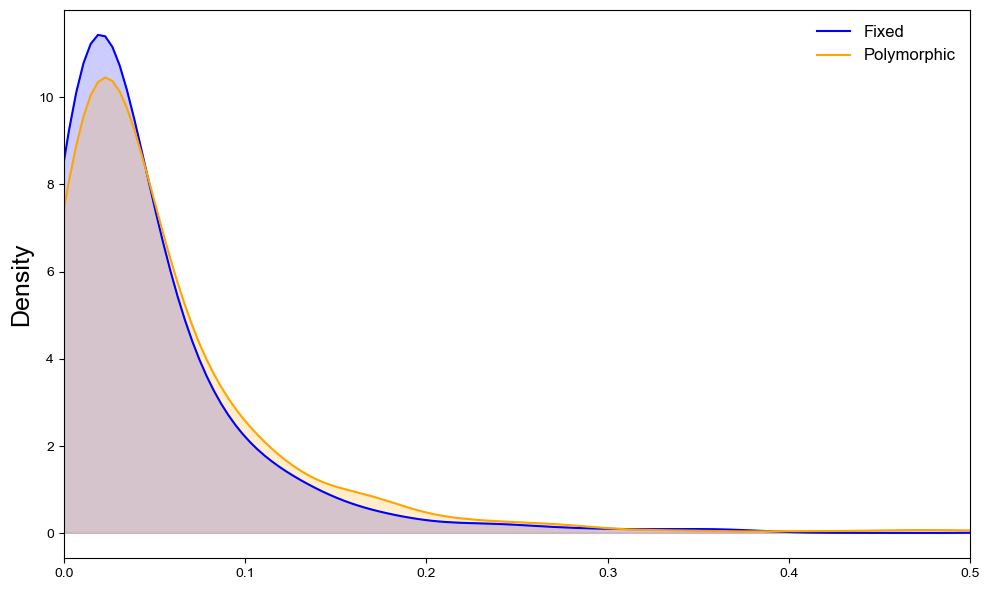

In [93]:
metric = "abs logfc"
v2k = v[(v["SpecSup447"] > -1) & (v["SpecSup447"] <= 19)].copy()
vv2k = vv[(vv["SpecSup447"] > -1) & (vv["SpecSup447"] <= 19)].copy()

v2k = v2k[v2k[1].isin(["AluYc"])]
vv2k = vv2k[vv2k[1].isin(["AluYc"])]

x2 = [np.float64(x) for x in list(v2k[metric])]
yvals2 = [np.float64(j) for j in list(vv2k[metric])]

yvals2.sort()
vvv = prepare_alpha(v2k, vv2k, stat = metric)
cuttt = 0.9
cutoff = yvals2[int(floor((len(yvals2)*cuttt)))]
alpha = compute_alpha_cutoff(vvv, dn_cut = 0.05, plot = True, cutoff = cutoff, window = [0, 0.5])
print(fisher_exact(alpha[-2]))
print(alpha)

SignificanceResult(statistic=0.8831328046066037, pvalue=1.0002787107351943e-38)
(-0.13229710199489408, 0.09826345, [[40115, 408804], [17757, 159820]], [[40115, 408804], [17758, 159819]], <Figure size 1000x600 with 1 Axes>)


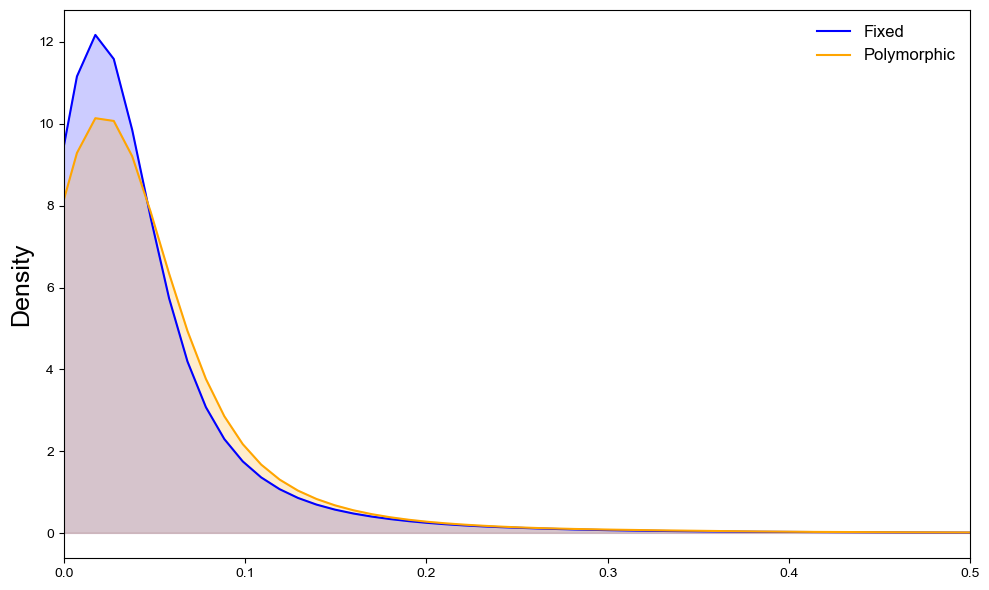

In [94]:
metric = "abs logfc"
v2k = v[(v["SpecSup447"] > -1) & (v["SpecSup447"] <= 19)].copy()
vv2k = vv[(vv["SpecSup447"] > -1) & (vv["SpecSup447"] <= 19)].copy()

v2k = v2k[~v2k[1].isin(recently_mobile)]
vv2k = vv2k[~vv2k[1].isin(recently_mobile)]

x2 = [np.float64(x) for x in list(v2k[metric])]
yvals2 = [np.float64(j) for j in list(vv2k[metric])]

yvals2.sort()
vvv = prepare_alpha(v2k, vv2k, stat = metric)
cuttt = 0.9
cutoff = yvals2[int(floor((len(yvals2)*cuttt)))]
alpha = compute_alpha_cutoff(vvv, dn_cut = 0.05, plot = True, cutoff = cutoff, window = [0, 0.5])
print(fisher_exact(alpha[-2]))
print(alpha)

In [34]:
dff

,RepeatClass,NumberFixedVariants,NumberPolymorphicVariants,NormalizedRatio
0,L1PA2,2791,7211,0.094572
1,L1PA3,13698,22909,0.146100
2,L1HS,349,557,0.153098
3,LTR5A,497,430,0.282415
4,L1PA4,34321,24147,0.347294
...,...,...,...,...
1068,HY1,140,19,1.800423
1069,(AT)n,104,14,1.815120
1070,UCON4,135,18,1.832573
1071,LTR16D1,251,31,1.978391


In [106]:
dff = pd.read_csv("Repeat_NumVar.txt", sep = "\t").drop(["Unnamed: 0"], axis = 1)

v2 = v[(v["SpecSup447"] > -1) & (v["SpecSup447"] <= 19)].copy()
vv2 = vv[(vv["SpecSup447"] > -1) & (vv["SpecSup447"] <= 19)].copy()
out = []
v_count = Counter(v[1])
vv_count = Counter(vv[1])

for i in dff["RepeatClass"]:
    if v_count[i] > 500 or vv_count[i] > 500:
        v2k = v[v[1].isin([i])]
        vv2k = vv[vv[1].isin([i])]
        vvv = prepare_alpha(v2k.copy(), vv2k.copy(), stat = metric)
        x2 = [np.float64(x) for x in list(v2k[metric])]
        yvals2 = [np.float64(j) for j in list(vv2k[metric])]
        yvals2.sort()
        cuttt = 0.5
        cutoff = yvals2[int(floor((len(yvals2)*cuttt)))]
        alpha = compute_alpha_cutoff(vvv, dn_cut = 0.05, plot = False, cutoff = cutoff, window = [0, 0.5])
        out.append([i] + list(alpha) + [fisher_exact(alpha[-1])[0], fisher_exact(alpha[-1])[1]])


KeyboardInterrupt



In [107]:
df = pd.DataFrame(out)
df.sort_values(1).head(50)

,0,1,2,3,4,5,6
5,SVA_A,-0.580535,0.039129,"[[243, 386], [198, 200]]","[[243, 386], [199, 199]]",0.629534,3.732712e-04
32,MST-int,-0.500022,0.022038,"[[428, 642], [185, 186]]","[[428, 642], [186, 185]]",0.663082,7.953374e-04
0,L1PA2,-0.447944,0.033575,"[[1143, 1655], [3738, 3739]]","[[1143, 1655], [3739, 3738]]",0.690450,1.180360e-16
2,L1HS,-0.275649,0.035126,"[[156, 199], [290, 291]]","[[156, 199], [291, 290]]",0.781226,6.912478e-02
18,HERVE-int,-0.259410,0.029618,"[[532, 670], [238, 239]]","[[532, 670], [239, 238]]",0.790708,3.415678e-02
37,Kanga1d,-0.251768,0.019873,"[[280, 354], [99, 101]]","[[280, 354], [100, 100]]",0.790960,1.662869e-01
40,PABL_A-int,-0.230076,0.020509,"[[426, 524], [146, 147]]","[[426, 524], [147, 146]]",0.807447,1.230747e-01
24,AluYc,-0.220289,0.030342,"[[2011, 2454], [816, 817]]","[[2011, 2454], [817, 816]]",0.818475,5.589289e-04
11,AluYe5,-0.203573,0.031388,"[[406, 491], [207, 209]]","[[406, 491], [208, 208]]",0.826884,1.221691e-01
1,L1PA3,-0.161349,0.030961,"[[6355, 7381], [11819, 11821]]","[[6355, 7381], [11820, 11820]]",0.860994,3.259002e-12


In [105]:
df["FDR"] = fdrcorrection(df[6])[1]
df[df[6] < 0.05].head(50)

,0,1,2,3,4,5,6,FDR
0,L1PA2,-0.447944,0.033575,"[[1143, 1655], [3738, 3739]]","[[1143, 1655], [3739, 3738]]",0.690450,1.180360e-16,4.221754e-14
1,L1PA3,-0.161349,0.030961,"[[6355, 7381], [11819, 11821]]","[[6355, 7381], [11820, 11820]]",0.860994,3.259002e-12,8.742272e-10
4,L1PA4,-0.118820,0.029786,"[[16227, 18158], [12456, 12460]]","[[16227, 18158], [12458, 12458]]",0.893656,1.466355e-11,3.146798e-09
5,HERVH-int,-0.068795,0.025262,"[[6621, 7078], [4681, 4683]]","[[6621, 7078], [4682, 4682]]",0.935434,1.309844e-02,4.933381e-01
6,SVA_A,-0.580535,0.039129,"[[243, 386], [198, 200]]","[[243, 386], [199, 199]]",0.629534,3.732712e-04,5.006500e-02
7,L1P1,-0.141148,0.031340,"[[2423, 2765], [1613, 1614]]","[[2423, 2765], [1614, 1613]]",0.875768,3.286268e-03,2.645398e-01
9,LTR7Y,-0.419109,0.030081,"[[141, 202], [104, 106]]","[[141, 202], [105, 105]]",0.698020,4.304612e-02,7.407503e-01
16,L1PA5,-0.059391,0.028969,"[[21179, 22439], [10406, 10408]]","[[21179, 22439], [10407, 10407]]",0.943848,6.050260e-04,6.491929e-02
19,AluY,-0.125211,0.023234,"[[40196, 45229], [18835, 18836]]","[[40196, 45229], [18836, 18835]]",0.888675,1.520519e-21,1.631516e-18
23,AluYk3,-0.147479,0.024544,"[[5068, 5818], [2258, 2260]]","[[5068, 5818], [2259, 2259]]",0.871090,1.040843e-04,1.595463e-02


In [ ]:
sns.kdeplot({"Negative":list(v2k[v2k["logfc"] < -0.1]["allele1_pred_counts"]), "Positive":list(v2k[v2k["logfc"] > 0.1]["allele1_pred_counts"])})

In [ ]:
sns.kdeplot({"Derived allele increases accessibility":list(vv2k[vv2k["fixed logfc"] < -0.1]["allele1_pred_counts"]), "Derived allele decreases accessibility":list(vv2k[vv2k["fixed logfc"] > 0.1]["allele1_pred_counts"])})

In [ ]:
v2k = v[(v["SpecSup447"] > -1) & (v["SpecSup447"] <= 19)].copy()
#v2k = v2k[v2k["PhyloP447"] < 0.25]
vv2k = vv[(vv["SpecSup447"] > -1) & (vv["SpecSup447"] <= 19)].copy()
#vv2k = vv2k[vv2k["PhyloP447"] < 0.25]
v2k = v2k[~v2k[1].isin(dff.head(50)[0])]
vv2k = vv2k[~vv2k[1].isin(dff.head(50)[0])]

x2 = [np.float64(x) for x in list(v2k[metric])]
yvals2 = [np.float64(j) for j in list(vv2k[metric])]
yvals2.sort()
vvv = prepare_alpha(v2k, vv2k, stat = metric)
cuttt = 0.99
cutoff = yvals2[int(floor((len(yvals2)*cuttt)))]
alpha = compute_alpha_cutoff(vvv, dn_cut = 0.05, plot = True, cutoff = cutoff, window = [0, 0.5])
print(fisher_exact(alpha[-2]))
print(alpha)

In [108]:
v_tau = pd.read_csv("Taus_HumanDerived_Group1_WithNeuron.txt", sep = "\t")
vv_tau = pd.read_csv("Taus_Polymorphic_Group1_WithNeuron.txt", sep = "\t")

v_tau = v_tau.set_index("Position")
vv_tau = vv_tau.set_index("Position")

In [112]:
v = v.join(v_tau)
vv = vv.join(vv_tau)

In [113]:
v = v.drop_duplicates("Position")
vv = vv.drop_duplicates("Position")

,Position,Position.1,NearestGene,NearestDist,PhyloP447,PhastCons447,SpecSup447,logfc,allele1_pred_counts,allele2_pred_counts,abs logfc,1,Tau_Allele1,Tau_Allele2,Tau_abs_logfc,Tau_jsd
Position,,,,,,,,,,,,,,,,
chr1:15446,chr1:15446,chr1:15446,OR4F5,53644,-1.587,0.000,383,-0.132272,693.00910,632.29690,0.132272,.,0.594114,0.585966,0.862151,0.767796
chr1:16497,chr1:16497,chr1:16497,OR4F5,52593,0.010,0.000,398,-0.013052,472.24908,467.99580,0.013052,.,0.530195,0.516792,0.922658,0.714811
chr1:16580,chr1:16580,chr1:16580,OR4F5,52510,-1.563,0.000,400,0.008982,437.20557,439.93616,0.008982,.,0.520899,0.548495,0.698928,0.782135
chr1:19051,chr1:19051,chr1:19051,OR4F5,50039,-0.060,0.000,411,0.025041,371.92870,378.44073,0.025041,.,0.626284,0.618649,0.513779,0.460373
chr1:39163,chr1:39163,chr1:39163,OR4F5,29927,-1.209,0.000,222,0.048970,407.02832,421.08130,0.048970,MLT1F2-int,0.566587,0.564375,0.761000,0.486010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrY:56878783,chrY:56878783,chrY:56878783,CDY1,31256667,1.497,0.006,182,-0.005613,473.32645,471.48843,0.005613,MIRb,0.466875,0.467980,0.771688,0.412623
chrY:56878814,chrY:56878814,chrY:56878814,CDY1,31256698,-0.145,0.000,103,0.022943,472.42620,479.99910,0.022943,MIRb,0.461385,0.467746,0.670443,0.325098
chrY:56884539,chrY:56884539,chrY:56884539,CDY1,31262423,0.535,0.000,244,0.080384,470.96396,497.94990,0.080384,MamRep1879,0.299340,0.335510,0.666948,0.671101


SignificanceResult(statistic=0.9658361754581548, pvalue=0.30783756573239307)
(-0.03509381350846341, 0.613, [[6449, 15573], [1541, 3596]], [[6455, 15567], [1543, 3594]], <Figure size 1000x600 with 1 Axes>)


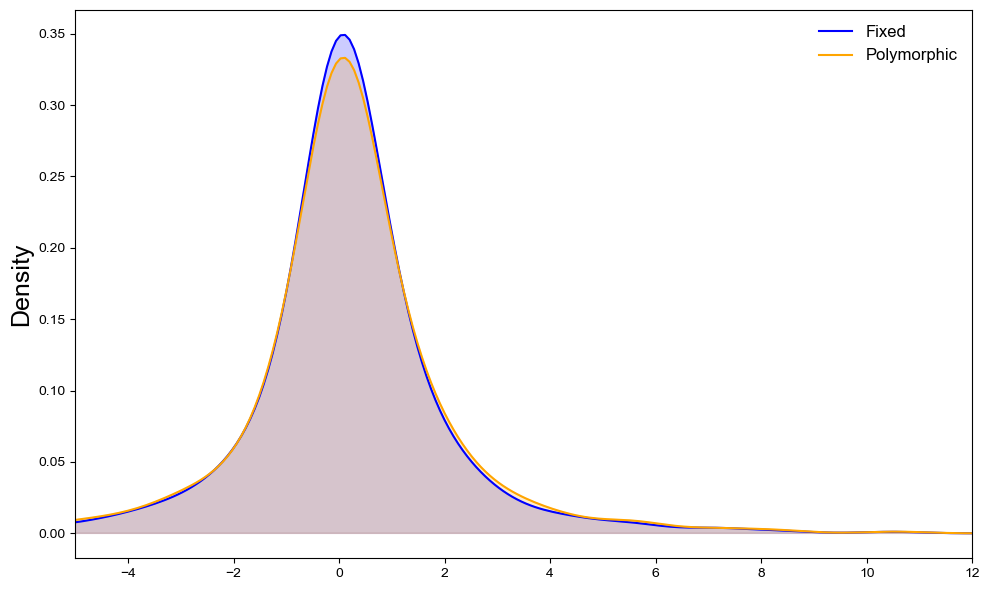

In [137]:
vk = v[(v["Tau_Allele1"] > 0.9) | (v["Tau_Allele2"] > 0.9)].copy()
vvk = vv[(vv["Tau_Allele1"] > 0.9) | (vv["Tau_Allele2"] > 0.9)].copy()
metric = "PhyloP447"
if metric == "PhyloP447":
    vk = vk[vk["SpecSup447"] > 250]
    vvk = vvk[vvk["SpecSup447"] > 250]

x2 = [np.float64(x) for x in list(vk[metric])]
yvals2 = [np.float64(j) for j in list(vvk[metric])]

yvals2.sort()
vvv = prepare_alpha(vk, vvk, stat = metric)
cuttt = 0.7
cutoff = yvals2[int(floor((len(yvals2)*cuttt)))]
alpha = compute_alpha_cutoff(vvv, dn_cut = 0.05, plot = True, cutoff = cutoff, window = [-5, 12])
print(fisher_exact(alpha[-2]))
print(alpha)

SignificanceResult(statistic=0.9078369454612405, pvalue=0.05696717692259407)
(-0.10004179363609778, 1.297, [[2335, 23129], [541, 4878]], [[2338, 23126], [543, 4876]], <Figure size 1000x600 with 1 Axes>)


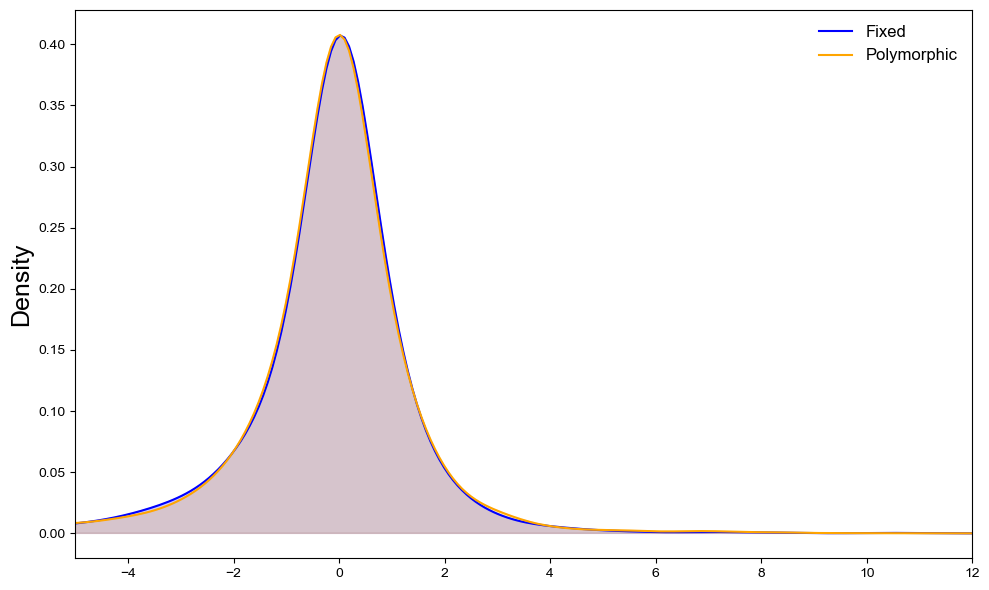

In [138]:
vk = v[(v["Tau_Allele1"] < 0.2) | (v["Tau_Allele2"] < 0.2)].copy()
vvk = vv[(vv["Tau_Allele1"] < 0.2) | (vv["Tau_Allele2"] < 0.2)].copy()
metric = "PhyloP447"
if metric == "PhyloP447":
    vk = vk[vk["SpecSup447"] > 250]
    vvk = vvk[vvk["SpecSup447"] > 250]

x2 = [np.float64(x) for x in list(vk[metric])]
yvals2 = [np.float64(j) for j in list(vvk[metric])]

yvals2.sort()
vvv = prepare_alpha(vk, vvk, stat = metric)
cuttt = 0.9
cutoff = yvals2[int(floor((len(yvals2)*cuttt)))]
alpha = compute_alpha_cutoff(vvv, dn_cut = 0.05, plot = True, cutoff = cutoff, window = [-5, 12])
print(fisher_exact(alpha[-2]))
print(alpha)

(129838, 19)

SignificanceResult(statistic=1.075064427969324, pvalue=3.872855556235974e-07)
(0.06989967286945153, 0.6917272164974249, [[92832, 37006], [20267, 8687]], [[92832, 37006], [20268, 8686]], <Figure size 1000x600 with 1 Axes>)
MannwhitneyuResult(statistic=1928752266.0, pvalue=1.7048941714653882e-12)


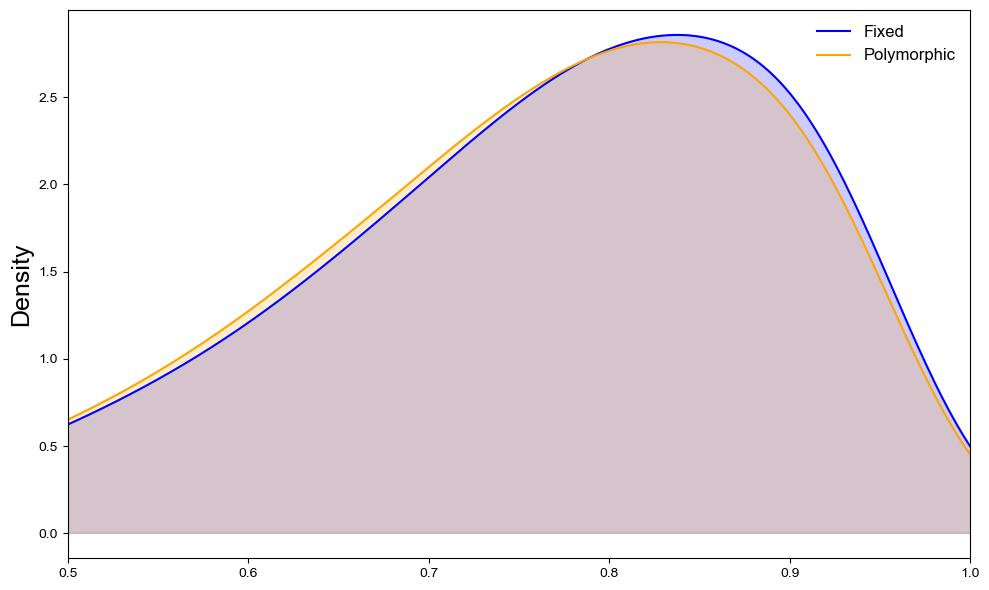

In [159]:
vk = v[(v["abs logfc"] > 0.2)].copy()
vvk = vv[(vv["abs logfc"] > 0.2)].copy()
metric = "Tau_abs_logfc"
vk = vk[vk["SpecSup447"] > 250]
vvk = vvk[vvk["SpecSup447"] > 250]
vk = vk[vk["PhyloP447"] <= 1]
vvk = vvk[vvk["PhyloP447"] <= 1]
x2 = [np.float64(x) for x in list(vk[metric])]
yvals2 = [np.float64(j) for j in list(vvk[metric])]

yvals2.sort()
vvv = prepare_alpha(vk, vvk, stat = metric)
cuttt = 0.3
cutoff = yvals2[int(floor((len(yvals2)*cuttt)))]
alpha = compute_alpha_cutoff(vvv, dn_cut = 0.05, plot = True, cutoff = cutoff, window = [0.5, 1])
print(fisher_exact(alpha[-2]))
print(alpha)
print(mwu(x2, yvals2, alternative = "greater"))

In [162]:
vk

,Position,Position.1,NearestGene,NearestDist,PhyloP447,PhastCons447,SpecSup447,logfc,allele1_pred_counts,allele2_pred_counts,abs logfc,1,Tau_Allele1,Tau_Allele2,Tau_abs_logfc,Tau_jsd,FixedOrPoly,MAFMaxAcrossAncestry,UnfoldedMAF
Position,,,,,,,,,,,,,,,,,,,
chr1:916775,chr1:916775,chr1:916775,SAMD11,8961,10.207,1.000,425,0.420920,2686.34330,3596.42580,0.420920,.,0.547328,0.521444,0.860475,0.849150,Fixed,.,.
chr1:4908390,chr1:4908390,chr1:4908390,AJAP1,253695,3.857,1.000,429,-0.202246,1309.44510,1138.16500,0.202246,.,0.527908,0.573840,0.789746,0.747116,Fixed,.,.
chr1:4951452,chr1:4951452,chr1:4951452,AJAP1,296757,4.427,1.000,431,-0.241447,1328.14310,1123.47130,0.241447,.,0.755317,0.712647,0.935173,0.760628,Fixed,.,.
chr1:5265631,chr1:5265631,chr1:5265631,AJAP1,610936,4.573,1.000,374,0.658070,1475.34020,2328.04270,0.658070,.,0.583731,0.715388,0.844030,0.685523,Fixed,.,.
chr1:5447652,chr1:5447652,chr1:5447652,NPHP4,544755,3.113,1.000,431,0.481829,1575.76340,2200.57450,0.481829,.,0.644156,0.736193,0.890369,0.832336,Fixed,.,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX:150232410,chrX:150232410,chrX:150232410,MAMLD1,130888,6.942,1.000,337,-0.224846,1030.40270,881.70170,0.224846,.,0.551379,0.588630,0.629375,0.611238,Fixed,.,.
chrX:151001114,chrX:151001114,chrX:151001114,HMGB3,17771,4.114,1.000,418,0.215589,415.12555,482.03460,0.215589,.,0.339376,0.534666,0.698291,0.722327,Fixed,.,.
chrX:151696177,chrX:151696177,chrX:151696177,PRRG3,0,4.665,1.000,433,0.230388,2965.53220,3479.01540,0.230388,.,0.655661,0.679615,0.517077,0.646821,Fixed,.,.


In [164]:
vvk

,Unnamed: 0,Position,MAFMaxAcrossAncestry,NearestGene,NearestDist,PhyloP447,PhastCons447,SpecSup447,logfc,allele1_pred_counts,...,Chimp ref,Gorilla ref,UnfoldedMAF,fixed logfc,1,Tau_Allele1,Tau_Allele2,Tau_abs_logfc,Tau_jsd,FixedOrPoly
Position,,,,,,,,,,,,,,,,,,,,,
chr10:101242306,chr10:101242306,chr10:101242306,0.424085,LBX1,13034,5.933,1.000,422,0.239296,1450.21530,...,G,G,0.424085,-0.239296,.,0.561550,0.542816,0.782760,0.674807,Polymorphic
chr10:10179008,chr10:10179008,chr10:10179008,0.363181,CELF2,986286,4.160,1.000,431,-0.336573,345.93472,...,T,T,0.363181,0.336573,.,0.612507,0.649158,0.811087,0.923731,Polymorphic
chr10:102646093,chr10:102646093,chr10:102646093,0.281901,TRIM8,1316,2.444,0.466,437,-0.233117,6215.15800,...,G,G,0.281901,0.233117,.,0.651391,0.657505,0.682263,0.521051,Polymorphic
chr10:102669989,chr10:102669989,chr10:102669989,0.396653,TRIM8,25212,3.455,1.000,418,-0.715312,789.20030,...,G,G,0.396653,0.715312,.,0.465117,0.538640,0.390196,0.316543,Polymorphic
chr10:10369033,chr10:10369033,chr10:10369033,0.395640,CELF2,796260,3.116,1.000,446,-0.291166,739.28880,...,C,C,0.395640,0.291166,.,0.360806,0.397683,0.862410,0.943937,Polymorphic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX:50770860,chrX:50770860,chrX:50770860,0.383800,SHROOM4,43291,3.960,1.000,439,-0.259927,1415.67140,...,C,C,0.616200,-0.259927,.,0.396702,0.416808,0.591248,0.584364,Polymorphic
chrX:69362966,chrX:69362966,chrX:69362966,0.329594,FAM155B,142274,2.284,1.000,426,-0.341431,2029.50060,...,T,T,0.670406,-0.341431,.,0.706348,0.629502,0.736986,0.672056,Polymorphic
chrX:70220391,chrX:70220391,chrX:70220391,0.711152,AWAT1,14216,3.942,1.000,434,0.748607,804.40380,...,G,G,0.288848,0.748607,.,0.437603,0.410900,0.506760,0.589541,Polymorphic


SignificanceResult(statistic=1.0323054331864905, pvalue=0.2178554082956661)
(0.03152025783604734, 0.7776253063120466, [[10545, 10215], [4288, 4290]], [[10545, 10215], [4289, 4289]], <Figure size 1000x600 with 1 Axes>)
MannwhitneyuResult(statistic=89525921.0, pvalue=0.23057116388343712)


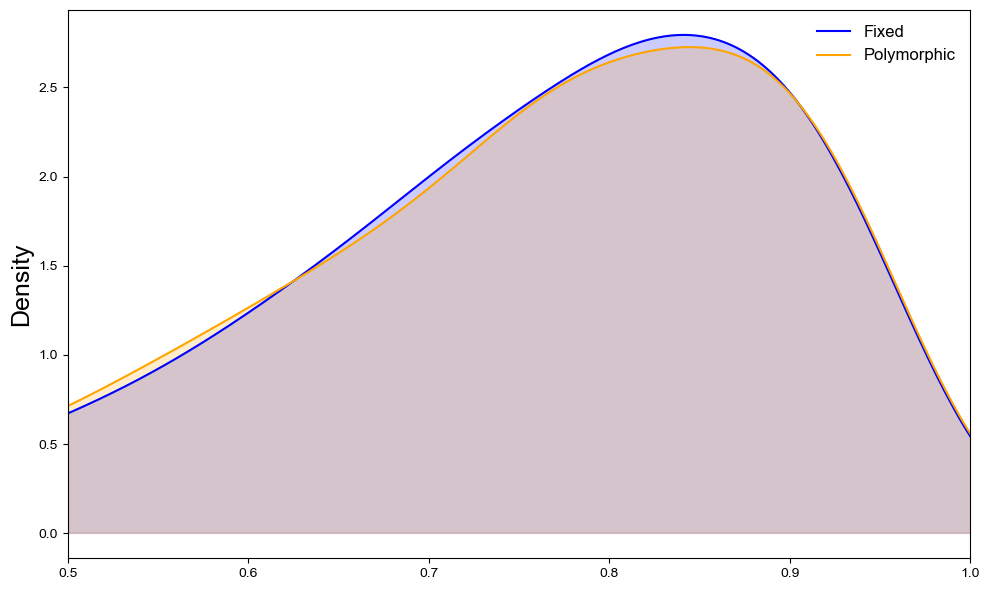

In [166]:
vk = v[(v["abs logfc"] > 0.2)].copy()
vvk = vv[(vv["abs logfc"] > 0.2)].copy()
vk = vvk[vvk["UnfoldedMAF"] < 0.35]
vvk = vvk[vvk["UnfoldedMAF"] > 0.65]

x2 = [np.float64(x) for x in list(vk[metric])]
yvals2 = [np.float64(j) for j in list(vvk[metric])]

yvals2.sort()
vvv = prepare_alpha(vk, vvk, stat = metric)
cuttt = 0.5
cutoff = yvals2[int(floor((len(yvals2)*cuttt)))]
alpha = compute_alpha_cutoff(vvv, dn_cut = 0.05, plot = True, cutoff = cutoff, window = [0.5, 1])
print(fisher_exact(alpha[-2]))
print(alpha)
print(mwu(x2, yvals2, alternative = "greater"))

SignificanceResult(statistic=1.1044211809908133, pvalue=0.015631742901015735)
(0.09514974566058487, 0.7136076529654775, [[10666, 4134], [2508, 1075]], [[10666, 4134], [2509, 1074]], <Figure size 1000x600 with 1 Axes>)
MannwhitneyuResult(statistic=27473758.0, pvalue=0.00038054940822818763)


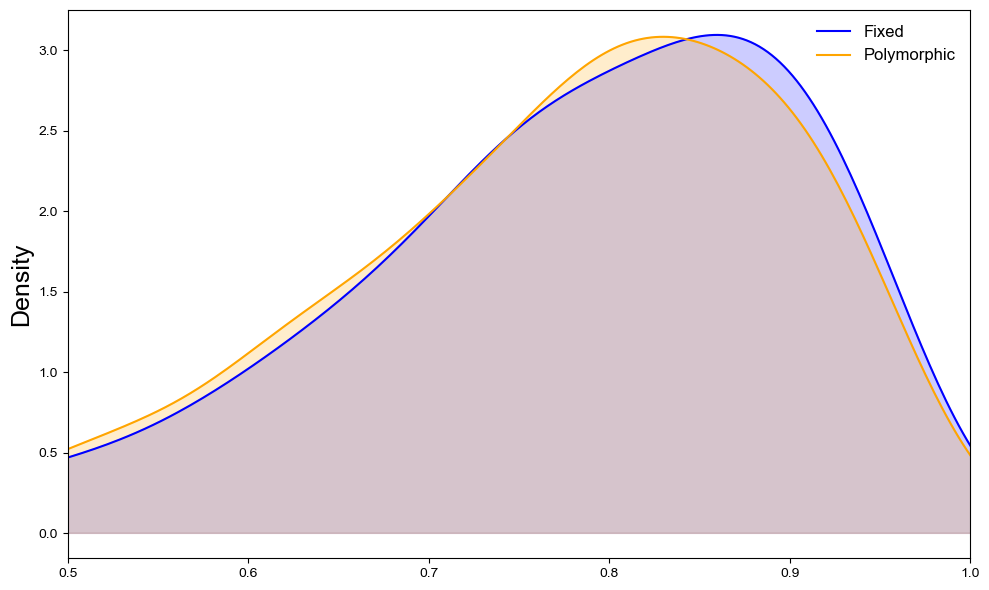

In [163]:
vk = v[(v["abs logfc"] > 0.2)].copy()
vvk = vv[(vv["abs logfc"] > 0.2)].copy()
metric = "Tau_abs_logfc"
vk = vk[vk["SpecSup447"] > 250]
vvk = vvk[vvk["SpecSup447"] > 250]
vk = vk[vk["PhyloP447"] > 2]
vvk = vvk[vvk["PhyloP447"] > 2]
x2 = [np.float64(x) for x in list(vk[metric])]
yvals2 = [np.float64(j) for j in list(vvk[metric])]

yvals2.sort()
vvv = prepare_alpha(vk, vvk, stat = metric)
cuttt = 0.3
cutoff = yvals2[int(floor((len(yvals2)*cuttt)))]
alpha = compute_alpha_cutoff(vvv, dn_cut = 0.05, plot = True, cutoff = cutoff, window = [0.5, 1])
print(fisher_exact(alpha[-2]))
print(alpha)
print(mwu(x2, yvals2, alternative = "greater"))

SignificanceResult(statistic=0.9500688367226053, pvalue=5.7085173369286686e-05)
(-0.05246550800031269, 0.5539999999999999, [[46535, 114366], [10906, 25469]], [[46577, 114324], [10917, 25458]], <Figure size 1000x600 with 1 Axes>)


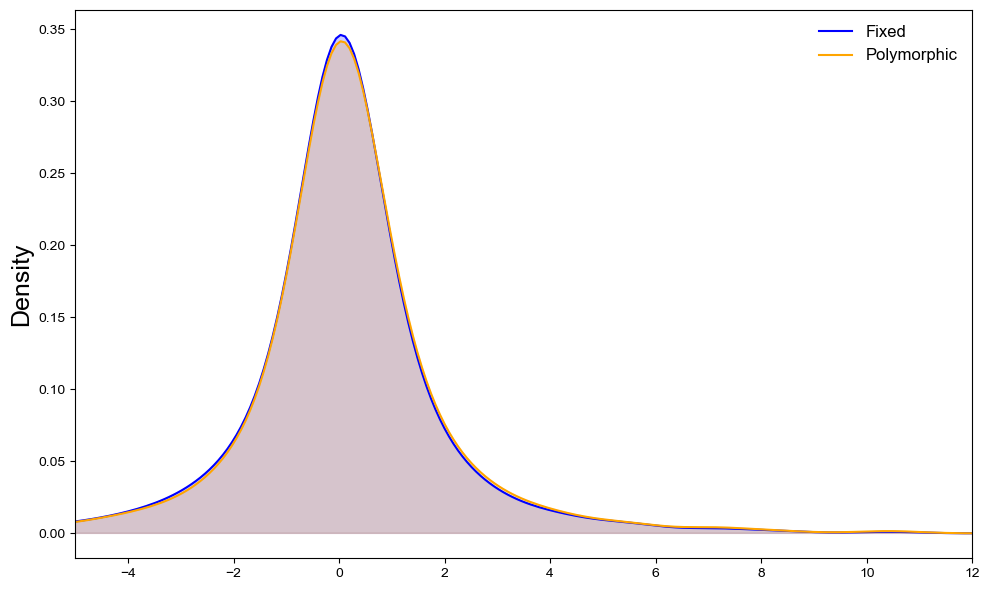

In [152]:
vk = v[(v["abs logfc"] > 0.2)].copy()
vvk = vv[(vv["abs logfc"] > 0.2)].copy()
metric = "PhyloP447"
if metric == "PhyloP447":
    vk = vk[vk["SpecSup447"] > 250]
    vvk = vvk[vvk["SpecSup447"] > 250]
x2 = [np.float64(x) for x in list(vk[metric])]
yvals2 = [np.float64(j) for j in list(vvk[metric])]

yvals2.sort()
vvv = prepare_alpha(vk, vvk, stat = metric)
cuttt = 0.7
cutoff = yvals2[int(floor((len(yvals2)*cuttt)))]
alpha = compute_alpha_cutoff(vvv, dn_cut = 0.05, plot = True, cutoff = cutoff, window = [-5, 12])
print(fisher_exact(alpha[-2]))
print(alpha)

In [146]:
vk.sort_values("Tau_abs_logfc").tail(50)

,Position,Position.1,NearestGene,NearestDist,PhyloP447,PhastCons447,SpecSup447,logfc,allele1_pred_counts,allele2_pred_counts,abs logfc,1,Tau_Allele1,Tau_Allele2,Tau_abs_logfc,Tau_jsd,FixedOrPoly,MAFMaxAcrossAncestry,UnfoldedMAF
Position,,,,,,,,,,,,,,,,,,,
chr11:81385563,chr11:81385563,chr11:81385563,FAM181B,1348286,-0.137,0.012,170,0.641262,238.844860,372.524630,0.641262,L1PB4,0.566702,0.516836,0.989713,0.902881,Fixed,.,.
chr10:31641718,chr10:31641718,chr10:31641718,ARHGAP12,287082,-0.879,0.000,14,-1.958485,67.937164,17.480135,1.958485,L1PA5,0.541613,0.552797,0.989823,0.955533,Fixed,.,.
chrX:75808703,chrX:75808703,chrX:75808703,MAGEE2,23478,0.112,0.003,6,-1.342687,74.039980,29.192902,1.342687,L1PA4,0.558215,0.580765,0.989894,0.828568,Fixed,.,.
chr3:74306007,chr3:74306007,chr3:74306007,CNTN3,215133,-0.017,0.000,331,-0.383755,362.620940,277.927200,0.383755,.,0.527156,0.482062,0.989951,0.887543,Fixed,.,.
chr8:61476175,chr8:61476175,chr8:61476175,CLVS1,188185,0.175,0.033,12,-1.157191,32.062600,14.376378,1.157191,L1PA4,0.600879,0.618464,0.989976,0.786342,Fixed,.,.
chr10:36370067,chr10:36370067,chr10:36370067,FZD8,728800,-0.106,0.000,280,-0.566073,1268.836500,857.039550,0.566073,L1ME3G,0.524330,0.482343,0.989985,0.870061,Fixed,.,.
chr15:92003914,chr15:92003914,chr15:92003914,SLCO3A1,150190,-0.006,0.001,271,1.191376,865.939100,1977.549200,1.191376,.,0.540548,0.746048,0.989994,0.957651,Fixed,.,.
chr1:96561129,chr1:96561129,chr1:96561129,PTBP2,160546,0.083,0.000,238,-0.341719,391.322450,308.792760,0.341719,MER21C,0.318834,0.347568,0.990018,0.861118,Fixed,.,.
chr21:18511713,chr21:18511713,chr21:18511713,TMPRSS15,107941,-0.110,0.130,249,-0.261549,649.173900,541.535640,0.261549,.,0.719562,0.663900,0.990085,0.257637,Fixed,.,.


In [ ]:
### Significant bias toward up or downregulation disappears when controlling for total accessibility
### But the polymorphisms generally having larger effects does not

x = v2k[v2k["abs logfc"] > 0.25]
y = vv2k[vv2k["abs logfc"] > 0.25]
up = x[x["logfc"] > 0].shape[0]
down = x[x["logfc"] < 0].shape[0]
up_poly = y[y["fixed logfc"] > 0].shape[0]
down_poly = y[y["fixed logfc"] < 0].shape[0]

fisher_exact([[up, down], [up_poly, down_poly]])